## **Mandelbrot**

To execute the code, please switch to a GPU instance on Colab.

In [1]:
# Cell to reset the environment.
%cd /content/
!rm -rf cuda_mandelbrot

/content


In [2]:
# Cell to setup the environment
!git clone https://github.com/elenalmg/cuda_mandelbrot.git
%cd cuda_mandelbrot/
!git checkout work_elena
!git submodule update --init --recursive

Cloning into 'cuda_mandelbrot'...
remote: Enumerating objects: 365, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 365 (delta 79), reused 92 (delta 44), pack-reused 218
Receiving objects: 100% (365/365), 742.15 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/cuda_mandelbrot
Branch 'work_elena' set up to track remote branch 'work_elena' from 'origin'.
Switched to a new branch 'work_elena'
Submodule 'pybind11' (https://github.com/pybind/pybind11) registered for path 'pybind11'
Cloning into '/content/cuda_mandelbrot/pybind11'...
Submodule path 'pybind11': checked out '8a099e44b3d5f85b20f05828d919d2332a8de841'


In [3]:
# Build the C++/CUDA library
!mkdir build
%cd build
!cmake -DCMAKE_CUDA_ARCHITECTURES="75" -DPython3_EXECUTABLE=`which python` ..
!make

/content/cuda_mandelbrot/build
Using CMake version 3.27.9
Using cmake policy CMP0104 NEW
-- The CXX compiler identification is GNU 11.4.0
-- The C compiler identification is GNU 11.4.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Setting build type to 'Release' as none was specified.
-- The CUDA compiler identification is NVIDIA 12.2.140
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Found Python3: /usr/local/bin/python (found version "3.10.12") 

In [6]:
import sys

# To import the C++ package
sys.path.append("/content/cuda_mandelbrot/build/src")

# To import the Python package
sys.path.append("/content/cuda_mandelbrot/mandelbrot_lib")

from mandelbrot_lib import NaiveSequential, NumpyGrid, NumbaCuda
from cuda_mandelbrot_lib import MandelbrotCPP, MandelbrotCUDA, FastMandelbrotCUDA, FasterMandelbrotCUDA, UnrolledMandelbrotCUDA

In [7]:
escape_radius = 2

# Initialize all algorithms
naive = NaiveSequential(escape_radius=escape_radius)
numpy = NumpyGrid(escape_radius=escape_radius)
numba = NumbaCuda(escape_radius=escape_radius)
cpp = MandelbrotCPP(escape_radius=escape_radius)
cuda = MandelbrotCUDA(escape_radius=escape_radius)
fast_cuda = FastMandelbrotCUDA(escape_radius=escape_radius)
faster_cuda = FasterMandelbrotCUDA(escape_radius=escape_radius)
unrolled = UnrolledMandelbrotCUDA(escape_radius=escape_radius)

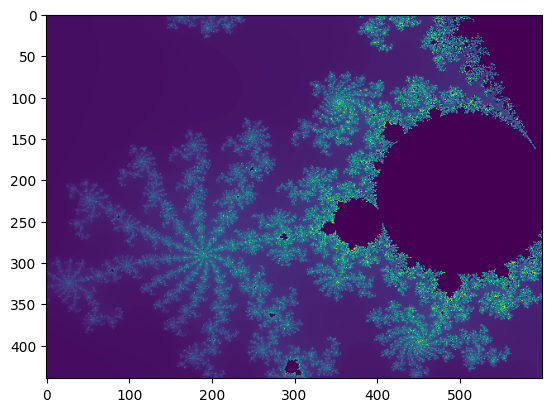

In [8]:
import matplotlib.pyplot as plt

width = 600
height = 440
xmin = -0.74
xmax = -0.69
ymin = 0.26
ymax = 0.3

n_iterations = 400

coords_inputs = [xmin, ymin, xmax, ymax, width, height, n_iterations]
complex_inputs = [complex(xmin, ymin), complex(xmax, ymax), width, height, n_iterations]

plt.imshow(cuda.compute_grid(*coords_inputs))

In [12]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt

width_height_ratio = 1.5
n_iterations = 200
n_samples = 10
x_min, x_max = -2.2, 0.5
y_min, y_max = -1, 1

def benchmark_mandelbrot(model, grid_sizes, n_samples, use_complex=False, method_name="compute_grid", no_iterations=False):
    times = []
    for width in grid_sizes:
        height = int(width / width_height_ratio)
        total_time = 0.0

        if use_complex:
            inputs = (complex(x_min, y_min), complex(x_max, y_max), width, height, n_iterations)
        else:
            inputs = (x_min, y_min, x_max, y_max, width, height, n_iterations)

        if no_iterations:
            inputs = inputs[:-1]

        method = getattr(model, method_name)

        for _ in range(n_samples):
            start_time = time.time()
            method(*inputs)
            end_time = time.time()
            total_time += end_time - start_time

        average_time = total_time / n_samples
        times.append((width, height, average_time))
        print(f"{type(model).__name__}.{method_name} with grid size {width}x{height}: {average_time:.4f} seconds")

    return times

# Exponentially bigger grid sizes
grid_sizes = [2, 3, 4, 6] + [round(8 * 2 ** (i/4)) for i in range(0, 47)]

naive_times = benchmark_mandelbrot(naive, grid_sizes[:22], n_samples=5, use_complex=True)
numpy_times = benchmark_mandelbrot(numpy, grid_sizes[:31], n_samples=40)
numba_times = benchmark_mandelbrot(numba, grid_sizes[:45], n_samples=40)
cpp_times = benchmark_mandelbrot(cpp, grid_sizes[:38], n_samples=5)
cuda_times = benchmark_mandelbrot(cuda, grid_sizes, n_samples=40)
fast_cuda_times = benchmark_mandelbrot(fast_cuda, grid_sizes, n_samples=40)
faster_cuda_times = benchmark_mandelbrot(faster_cuda, grid_sizes, n_samples=40)
unrolled_2_times = benchmark_mandelbrot(unrolled, grid_sizes, n_samples=40, method_name="compute_grid_2", no_iterations=True)
unrolled_3_times = benchmark_mandelbrot(unrolled, grid_sizes, n_samples=40, method_name="compute_grid_3", no_iterations=True)
unrolled_5_times = benchmark_mandelbrot(unrolled, grid_sizes, n_samples=40, method_name="compute_grid_5", no_iterations=True)
unrolled_10_times = benchmark_mandelbrot(unrolled, grid_sizes, n_samples=40, method_name="compute_grid_10", no_iterations=True)


NaiveSequential.compute_grid with grid size 2x1: 0.0000 seconds
NaiveSequential.compute_grid with grid size 3x2: 0.0004 seconds
NaiveSequential.compute_grid with grid size 4x2: 0.0004 seconds
NaiveSequential.compute_grid with grid size 6x4: 0.0009 seconds
NaiveSequential.compute_grid with grid size 8x5: 0.0017 seconds
NaiveSequential.compute_grid with grid size 10x6: 0.0022 seconds
NaiveSequential.compute_grid with grid size 11x7: 0.0034 seconds
NaiveSequential.compute_grid with grid size 13x8: 0.0037 seconds
NaiveSequential.compute_grid with grid size 16x10: 0.0052 seconds
NaiveSequential.compute_grid with grid size 19x12: 0.0072 seconds
NaiveSequential.compute_grid with grid size 23x15: 0.0114 seconds
NaiveSequential.compute_grid with grid size 27x18: 0.0170 seconds
NaiveSequential.compute_grid with grid size 32x21: 0.0255 seconds
NaiveSequential.compute_grid with grid size 38x25: 0.0665 seconds
NaiveSequential.compute_grid with grid size 45x30: 0.0737 seconds
NaiveSequential.compute

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 48 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


NumbaCuda.compute_grid with grid size 181x120: 0.0012 seconds
NumbaCuda.compute_grid with grid size 215x143: 0.0016 seconds
NumbaCuda.compute_grid with grid size 256x170: 0.0016 seconds
NumbaCuda.compute_grid with grid size 304x202: 0.0015 seconds
NumbaCuda.compute_grid with grid size 362x241: 0.0019 seconds
NumbaCuda.compute_grid with grid size 431x287: 0.0019 seconds
NumbaCuda.compute_grid with grid size 512x341: 0.0021 seconds
NumbaCuda.compute_grid with grid size 609x406: 0.0029 seconds
NumbaCuda.compute_grid with grid size 724x482: 0.0037 seconds
NumbaCuda.compute_grid with grid size 861x574: 0.0050 seconds
NumbaCuda.compute_grid with grid size 1024x682: 0.0066 seconds
NumbaCuda.compute_grid with grid size 1218x812: 0.0087 seconds
NumbaCuda.compute_grid with grid size 1448x965: 0.0116 seconds
NumbaCuda.compute_grid with grid size 1722x1148: 0.0167 seconds
NumbaCuda.compute_grid with grid size 2048x1365: 0.0229 seconds
NumbaCuda.compute_grid with grid size 2435x1623: 0.0315 seconds

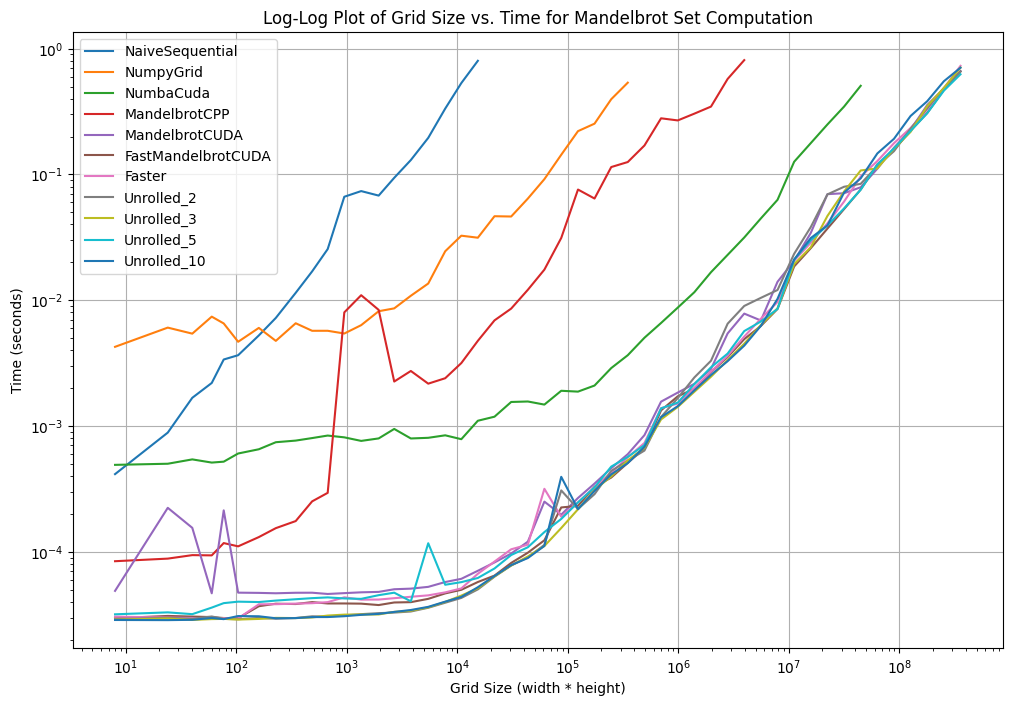

In [13]:
plt.figure(figsize=(12, 8))

def extract_sizes_times(benchmark_results: list) -> tuple[list, list]:
    """Helper function to extract time and grid size lists from results."""
    sizes = [w * h for w, h, t in benchmark_results]
    times = [t for w, h, t in benchmark_results]
    return sizes, times

models_and_times = [
    ("NaiveSequential", naive_times),
    ("NumpyGrid", numpy_times),
    ("NumbaCuda", numba_times),
    ("MandelbrotCPP", cpp_times),
    ("MandelbrotCUDA", cuda_times),
    ("FastMandelbrotCUDA", fast_cuda_times),
    ("Faster", faster_cuda_times),
    ("Unrolled_2", unrolled_2_times),
    ("Unrolled_3", unrolled_3_times),
    ("Unrolled_5", unrolled_5_times),
    ("Unrolled_10", unrolled_10_times),

]

for model_name, times in models_and_times:
    sizes, times = extract_sizes_times(times[2:])
    plt.plot(sizes, times, label=model_name)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grid Size (width * height)')
plt.ylabel('Time (seconds)')
plt.title('Log-Log Plot of Grid Size vs. Time for Mandelbrot Set Computation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tqdm import tqdm


def benchmark_fixed_grid(model_methods: list, grid: tuple, width: int, height: int, n_samples: int):
    """model_methods is a list of (name, class, method, no_iterations)."""
    times = {method_name: [] for (_, _, method_name, _) in model_methods}
    for _ in tqdm(range(n_samples)):
        for (name, model, method_name, no_iterations) in model_methods:

            method = getattr(model, method_name)
            inputs = list(grid) + [width, height, n_iterations]

            if no_iterations:
                inputs = inputs[:-1]

            start_time = time.time()
            method(*inputs)
            end_time = time.time()

            times[method_name].append(end_time - start_time)

    return times

model_methods = [
    ("MandelbrotCUDA", cuda_times, "compute_grid", False),
    ("FastMandelbrotCUDA", fast_cuda_times, "compute_grid", False),
    ("Faster", faster_cuda_times, "compute_grid", False),
    ("Unrolled_2", unrolled_2_times, "compute_grid_2", True),
    ("Unrolled_3", unrolled_3_times, "compute_grid_3", True),
    ("Unrolled_5", unrolled_5_times, "compute_grid_5", True),
    ("Unrolled_10", unrolled_10_times, "compute_grid_10", True),
]

grid_wide = [-2.2, -1, 0.5, 1]
grid_inner = [-0.35, 0.14, -0.33, 0.16]
grid_size = 5000
n_samples = 200

times_wide = benchmark_fixed_grid(
    model_methods, 
    grid=grid_wide, 
    width=grid_size,
    height=grid_size, 
    n_samples=n_samples
)

times_inner = benchmark_fixed_grid(
    model_methods, 
    grid=grid_inner, 
    width=grid_size,
    height=grid_size, 
    n_samples=n_samples
)
